# Insurance Cost Analysis

This notebook contains data analysis and builds regression models to predict insurance charges based on the Medical Cost Personal Dataset, which can be found on [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance/data).

## Data Summary

This part contains all actions performed to achieve various informative aspects of the dataset.  

The dataset consists of 1338 rows and 7 columns, with the **charges** column being the target variable. All other variables seem informative and usable for the regression task, with standout columns being **smoker**, **age**, and **sex**.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [21]:
df.shape

(1338, 7)

## Objective Analysis

In this section, we analyze the distributions of the various features in the dataset to identify which ones are most useful for predicting medical insurance charges. This analysis helps us understand the relationships between personal and lifestyle factors and the amount people are likely to be charged.

Text(0.5, 1.0, 'Sex Distribution')

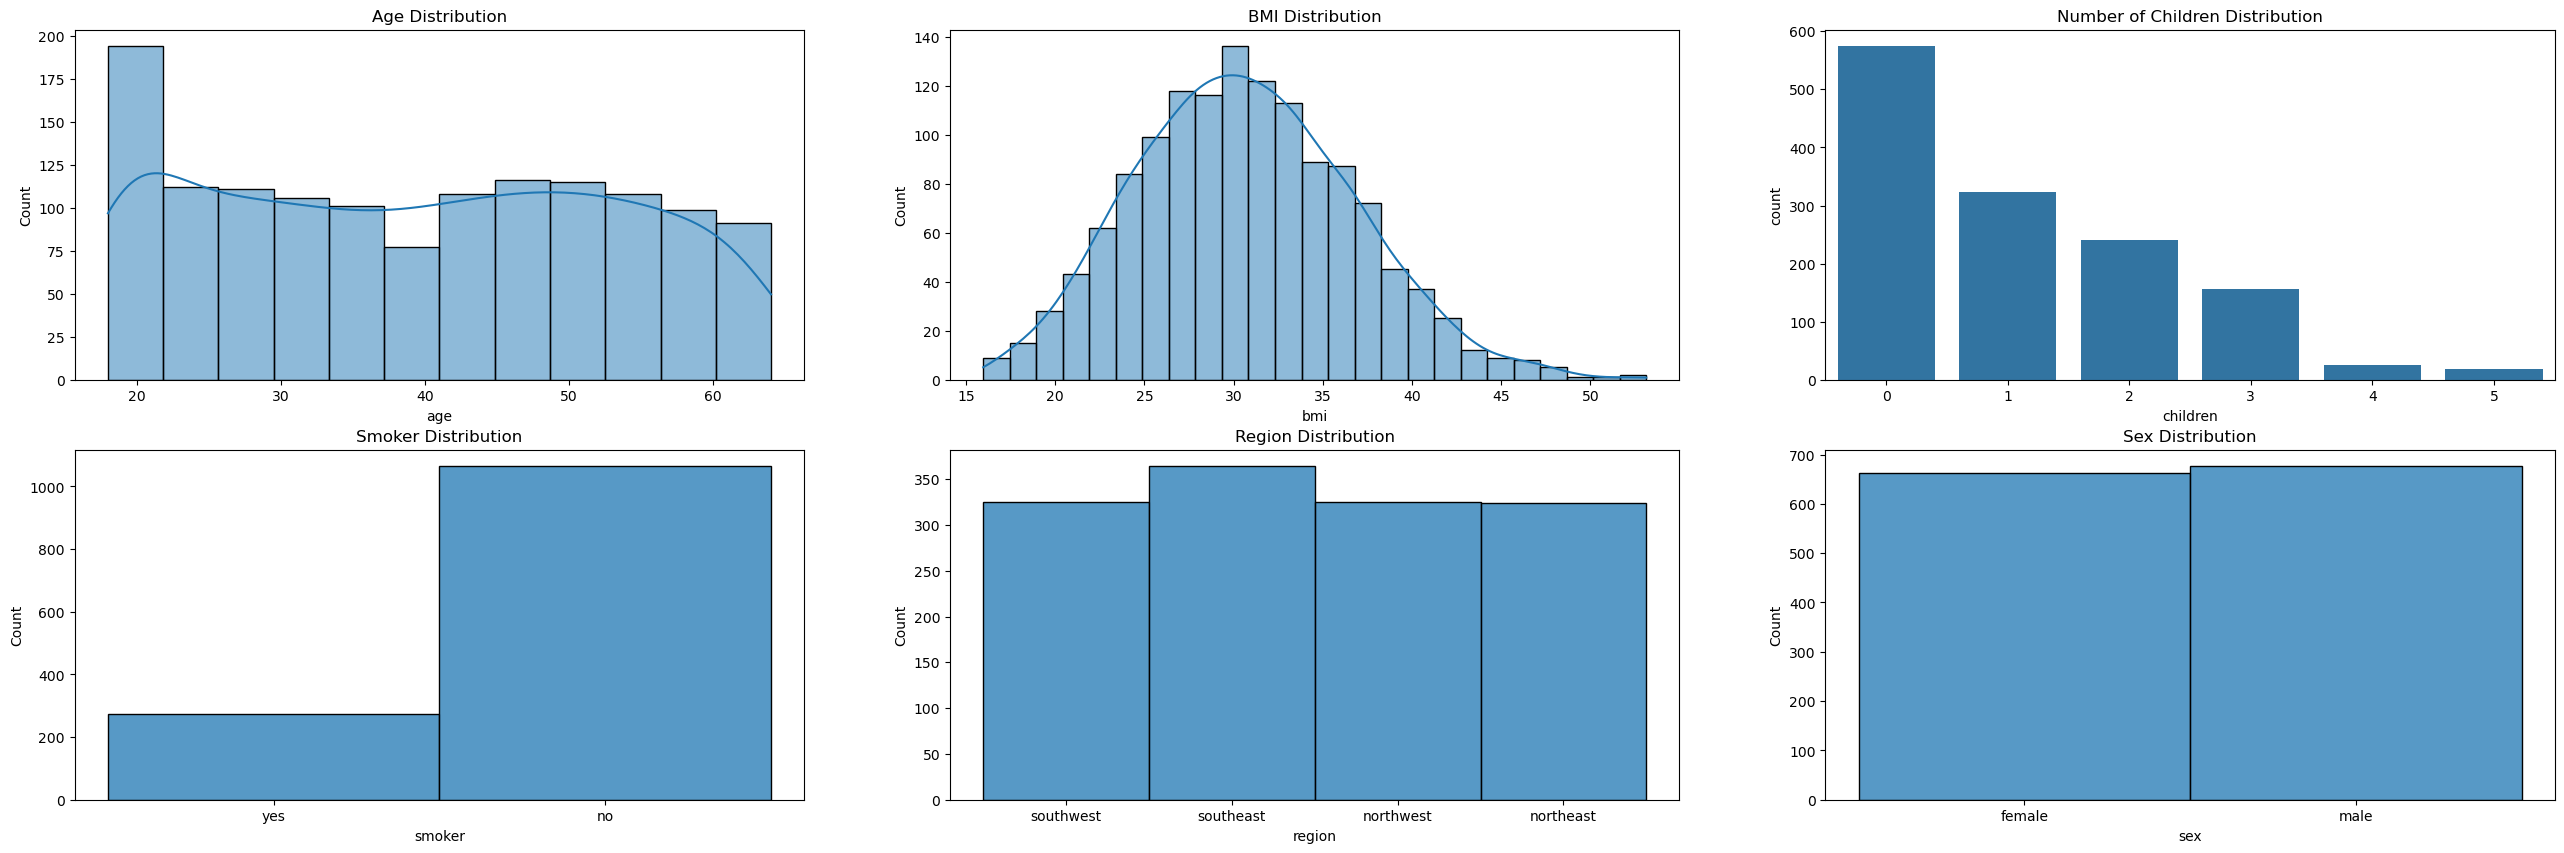

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(32,10))
sns.histplot(data=df, x='age', kde=True, ax=axes[0,0]).set_title('Age Distribution')
sns.histplot(data=df, x='bmi', kde=True, ax=axes[0,1]).set_title('BMI Distribution')
sns.countplot(data=df, x='children', ax=axes[0,2]).set_title('Number of Children Distribution')
sns.histplot(data=df, x='smoker', ax=axes[1,0]).set_title('Smoker Distribution')
sns.histplot(data=df, x='region', ax=axes[1,1]).set_title('Region Distribution')
sns.histplot(data=df, x='sex', ax=axes[1,2]).set_title('Sex Distribution')

Text(0.5, 1.0, 'Distibution of charges')

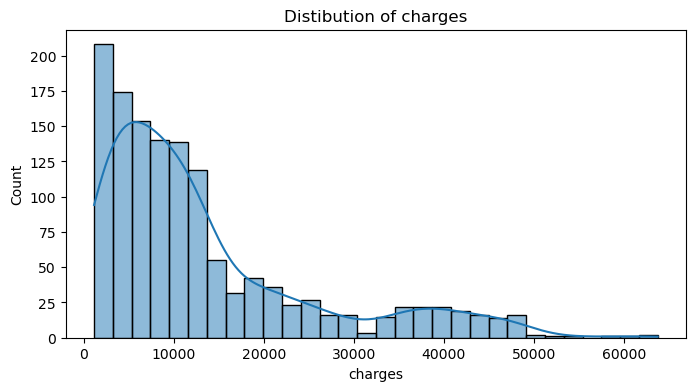

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='charges',kde=True).set_title('Distibution of charges')

Text(0.5, 1.0, 'Log Distibution of charges')

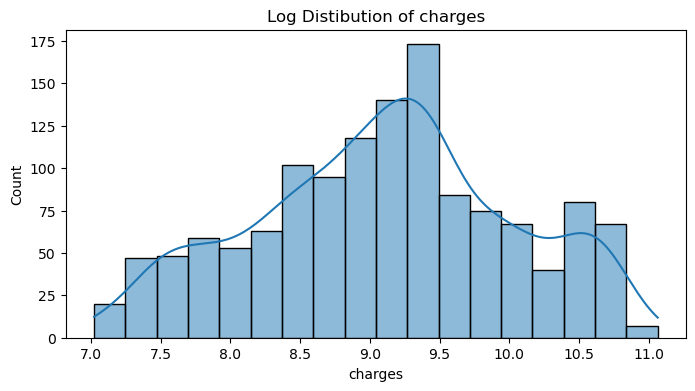

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(data=df, x=np.log(df['charges']),kde=True).set_title('Log Distibution of charges')

Text(0.5, 1.0, 'Charges by Sex')

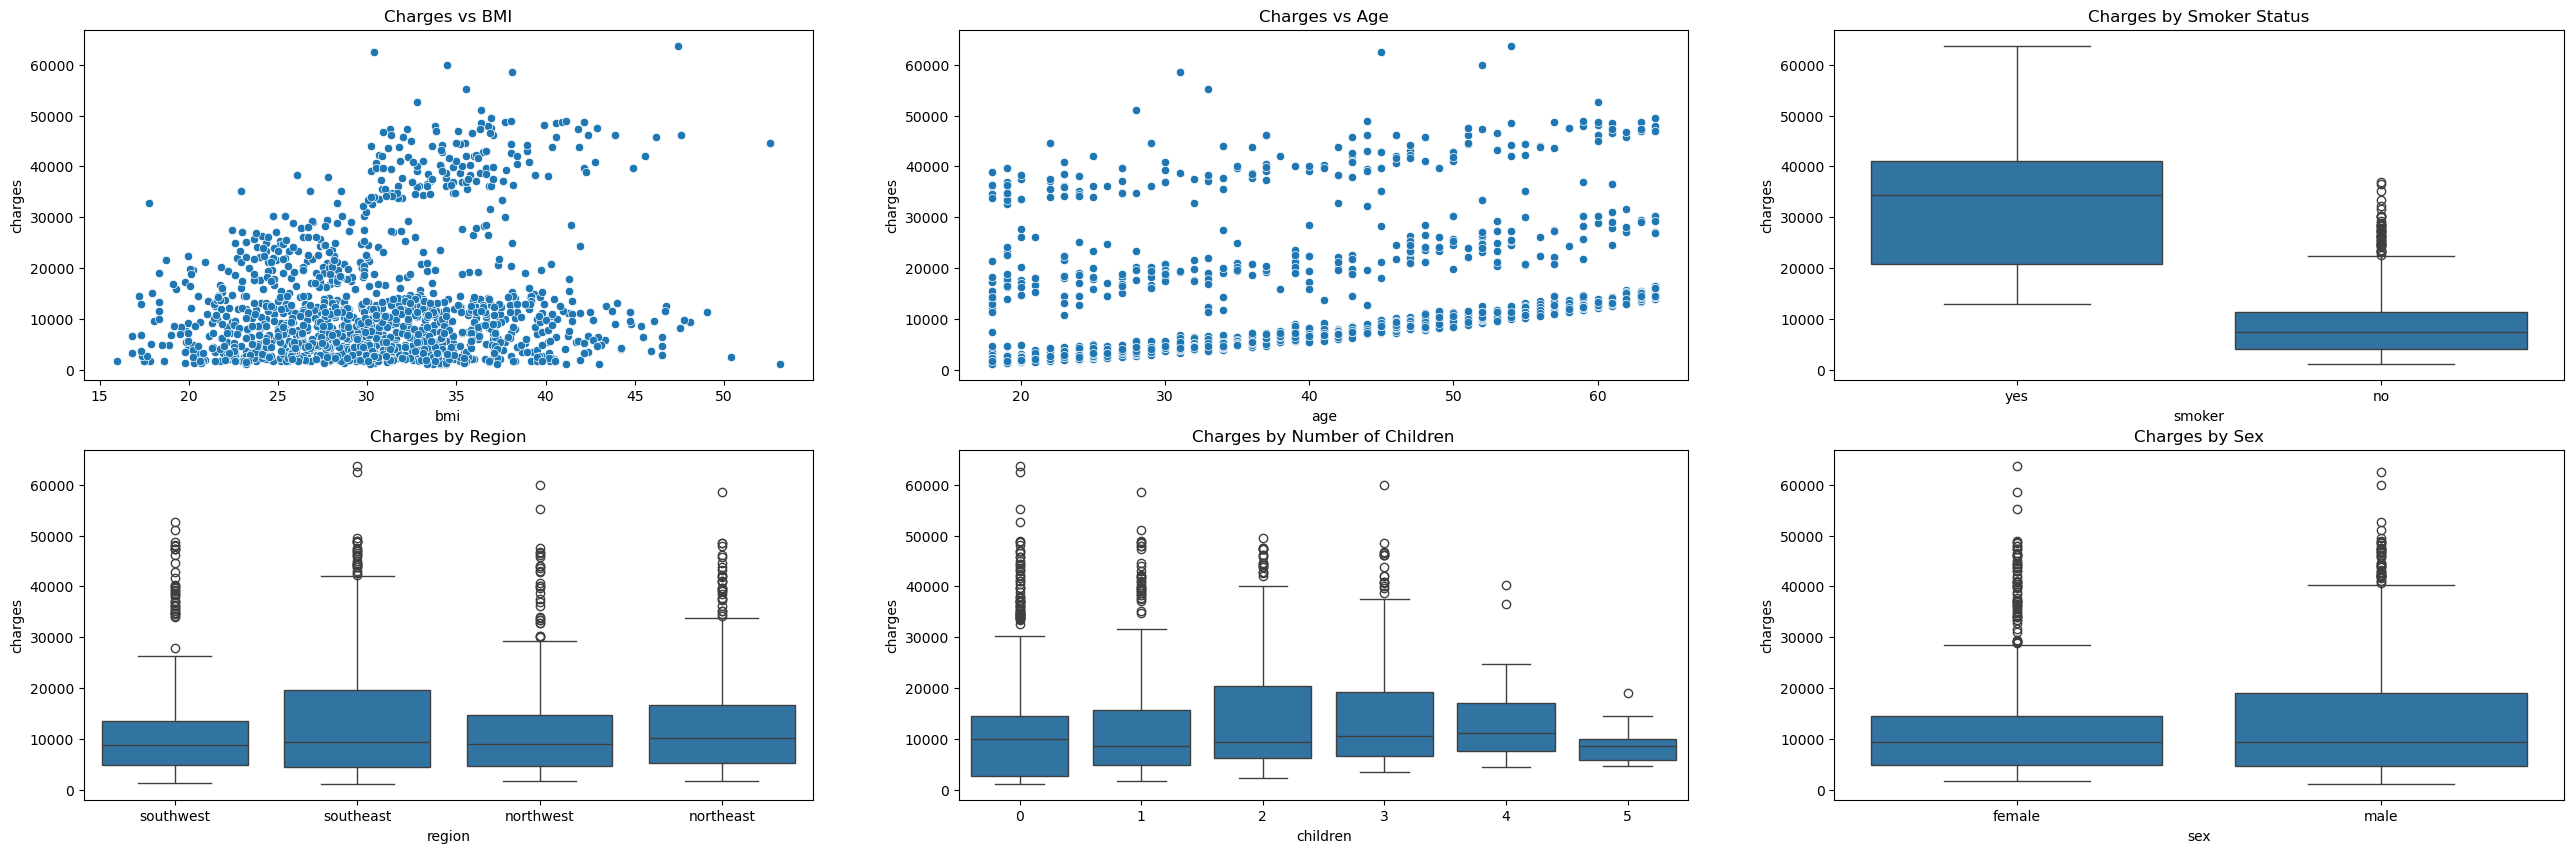

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(32,10))
sns.scatterplot(data=df, x='bmi', y='charges', ax=axes[0,0]).set_title('Charges vs BMI')
sns.scatterplot(data=df, x='age', y='charges', ax=axes[0,1]).set_title('Charges vs Age')
sns.boxplot(data=df, x='smoker', y='charges', ax=axes[0,2]).set_title('Charges by Smoker Status')
sns.boxplot(data=df, x='region', y='charges', ax=axes[1,0]).set_title('Charges by Region')
sns.boxplot(data=df, x='children', y='charges', ax=axes[1,1]).set_title('Charges by Number of Children')
sns.boxplot(data=df, x='sex', y='charges', ax=axes[1,2]).set_title('Charges by Sex')

## Model Comparison

In this section, we create six regression models and compare their performance. The models are:

- Linear Regression (no regularization)  
- Ridge Regression (Linear Regression with Ridge regularization)  
- Lasso Regression (Linear Regression with Lasso regularization)  
- Elastic Net Regression (Linear Regression with Elastic Net regularization)  
- XGBoost Regressor  
- Random Forest Regressor  

We evaluate these models using the **Root Mean Squared Error (RMSE)**, which measures how close the predicted values are to the true values, while penalizing larger errors more heavily. This gives insight into which models perform best, especially in the presence of outliers.

The performance summary for these models on the validation data is as follows:

| Model                | RMSE      |
|---------------------|-----------|
| Random Forest       | 4,658.58  |
| XGBoost             | 4,965.79  |
| Elastic Net         | 6,200.43  |
| Ridge Regression    | 6,200.91  |
| Linear Regression   | 6,201.61  |
| Lasso Regression    | 6,201.61  |

This shows that the Random Forest Regressor is the best performer while all the linear regression techniques perform similarly, without gaining much extra performance from the additional regularization. For this reason, the Random Forest Regressor was used on the test data which gave a final RMSE of 
4338.20.

In [28]:
X = df.drop(columns=['charges'])
y = df['charges']
X.shape, y.shape

((1338, 6), (1338,))

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((936, 6), (402, 6), (936,), (402,))

In [71]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols, cat_cols

(Index(['age', 'bmi', 'children'], dtype='object'),
 Index(['sex', 'smoker', 'region'], dtype='object'))

In [72]:
num_transform = Pipeline(steps=[("scaler", StandardScaler())])
cat_transform = Pipeline(steps=[("ohe", OneHotEncoder())])

In [73]:
preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transform, num_cols),
            ("cat", cat_transform, cat_cols)
        ]
    )

In [74]:
models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.01),
        "Elastic Net": ElasticNet(alpha=0.01, l1_ratio=0.5)
    }

In [75]:
results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[
            ("preprocessing", preprocessor),
            ("model", model)
        ])

    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    results[name] = round(float(abs(scores.mean())), 3)

In [76]:
results

{'Linear Regression': 6201.614,
 'Ridge Regression': 6200.907,
 'Lasso Regression': 6201.612,
 'Elastic Net': 6200.433}

In [77]:
models2 = {
        'XGB': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    }

In [78]:
for name, model in models2.items():
    pipe = Pipeline(steps=[
            ("preprocessing", preprocessor),
            ("model", model)
        ])

    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    results[name] = round(float(abs(scores.mean())), 3)

In [79]:
results

{'Linear Regression': 6201.614,
 'Ridge Regression': 6200.907,
 'Lasso Regression': 6201.612,
 'Elastic Net': 6200.433,
 'XGB': 4965.791,
 'RandomForest': 4658.581}

In [84]:
final_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42))
])

final_pipe.fit(X_train,y_train)
y_hat = final_pipe.predict(X_test)
score = root_mean_squared_error(y_hat,y_test)
score

4338.199568592827

<Axes: xlabel='importance', ylabel='feature'>

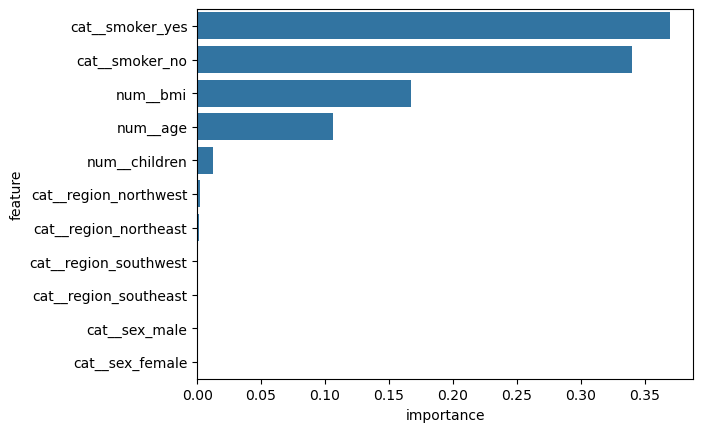

In [92]:
model = final_pipe.named_steps['model']
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': final_pipe.named_steps['preprocess'].get_feature_names_out(),
    'importance': importances
}).sort_values(by='importance', ascending=False)
sns.barplot(data=importance_df, x='importance',  y="feature")

## Key Findings

After extracting the feature importance from the random forest regressor, it shows that smoker, bmi and age play the largest role in predicting insurance costs. From the previous graphs, we see that smokers pay more for insurance than non smokers and the base insurance rate seems to increase with age which the model takes into account well.  

Although it uses the features well, the actual performance is not that great. The charges vary quite drastically between in and maximum with a std of around 12000, a rmse of 4338.2 is still much too large to be acceptable and would benefit from more features.

## Limitations and Next Steps

One of the main limitations of this dataset is its relatively small size. With only around 1,338 samples and a high variance in the target variable, it can be challenging for models to generalize well. Additionally, the dataset contains only six features, which limits the ability to capture complex relationships and interactions that may influence insurance charges.  

Future steps could include collecting more data, engineering new features (e.g., interactions between age, BMI, and smoking status), or incorporating external datasets to improve model performance and robustness.
